In [1]:
# Step 1: Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
import ccxt
import time

In [ ]:
# Bincance API Connecting
binance = ccxt.binance({
    'apiKey': 'YOUR_API_KEY',
    'secret': 'YOUR_SECRET_KEY',
    'enableRateLimit': True
})

In [8]:
def fetch_ohlcv_full(symbol, timeframe='5m', since=None, limit=1500, max_retries=5):
    all_candles = []
    since = since or binance.parse8601('2022-08-01T00:00:00Z')  # default: 1 year ago
    while True:
        try:
            candles = binance.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
            if not candles:
                break
            all_candles.extend(candles)

            # print(f"Fetched {len(candles)} candles since {binance.iso8601(since)}")

            # Move to next batch
            since = candles[-1][0] + 1  # Avoid duplicate timestamps

            # Respect rate limits
            time.sleep(binance.rateLimit / 1000)

        except ccxt.NetworkError as e:
            print("Network error:", e)
            max_retries -= 1
            if max_retries <= 0:
                break
            time.sleep(2)
        except Exception as e:
            print("Error:", e)
            break

    df = pd.DataFrame(all_candles, columns=['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')
    df.set_index('Timestamp', inplace=True)
    return df


In [9]:
# Fetch 1 year of 5-minute BTC/USDT candles
df = fetch_ohlcv_full('BTC/USDT', timeframe='5m')
# Preview
print(df.head())
print(f"Total candles fetched: {len(df)}")

                         Open      High       Low     Close     Volume
Timestamp                                                             
2022-08-01 00:00:00  23296.36  23317.72  23262.27  23277.42  651.57251
2022-08-01 00:05:00  23274.75  23285.84  23257.37  23277.32  474.05582
2022-08-01 00:10:00  23277.32  23314.99  23272.23  23281.41  406.89184
2022-08-01 00:15:00  23279.80  23339.05  23265.11  23290.96  673.13135
2022-08-01 00:20:00  23290.96  23325.00  23276.19  23318.44  260.18358
Total candles fetched: 316345


In [10]:
initial_balance = 10000  # Starting capital
risk_per_trade_pct = 1   # Risk 1% per trade
stop_loss_pct = 0.01     # 1% stop-loss
take_profit_pct = 0.02   # 2% take-profit

In [15]:
# Calculating RSI 
rsi = RSIIndicator(close=df["Close"], window=14)
df["RSI"] = rsi.rsi()
# preview the result
print(df[["Close", "RSI"]].tail(10))

                         Close        RSI
Timestamp                                
2025-08-03 10:35:00  113827.05  67.299445
2025-08-03 10:40:00  113810.55  64.204712
2025-08-03 10:45:00  113894.57  71.413419
2025-08-03 10:50:00  113870.63  67.257218
2025-08-03 10:55:00  113899.99  69.594372
2025-08-03 11:00:00  113972.45  74.442903
2025-08-03 11:05:00  114042.00  78.059401
2025-08-03 11:10:00  114231.95  84.507430
2025-08-03 11:15:00  114137.47  73.013537
2025-08-03 11:20:00  114153.06  73.650387


In [21]:
# Trade tracking
in_position = False
trades = []

for i in range(1, len(df)):
    rsi = df["RSI"].iloc[i]
    price = df["Close"].iloc[i]
    time = df.index[i]

    # Entry condition
    if not in_position and rsi < 30:
        entry_price = price
        entry_time = time
        stop_loss = entry_price * (1 - stop_loss_pct)
        take_profit = entry_price * (1 + take_profit_pct)

        # Calculate position size based on 1% capital risk
        dollar_risk = initial_balance * (risk_per_trade_pct / 100)
        risk_per_unit = entry_price - stop_loss
        position_size = dollar_risk / risk_per_unit

        in_position = True

    # Exit conditions
    elif in_position:
        if price <= stop_loss:
            exit_reason = "Stop Loss"
        elif price >= take_profit:
            exit_reason = "Take Profit"
        elif rsi > 70:
            exit_reason = "RSI Exit"
        else:
            continue

        exit_price = price
        exit_time = time
        pnl_pct = (exit_price - entry_price) / entry_price
        pnl_dollars = pnl_pct * entry_price * position_size

        trades.append({
            "Entry Time": entry_time,
            "Exit Time": exit_time,
            "Entry Price": entry_price,
            "Exit Price": exit_price,
            "PnL %": pnl_pct * 100,
            "PnL ($)": pnl_dollars,
            "Position Size": position_size,
            "Exit Reason": exit_reason
        })

        in_position = False

In [23]:
trades_df = pd.DataFrame(trades)
print(trades_df.tail())
print(f"Total Trades: {len(trades_df)}")

# Total PnL in dollars
total_profit = trades_df["PnL ($)"].sum()
print(f"Total Profit: ${total_profit:.2f}")

# Final capital = starting capital + total profit
final_capital = initial_balance + total_profit
print(f"Final Capital: ${final_capital:.2f}")

              Entry Time           Exit Time  Entry Price  Exit Price  \
1770 2025-08-01 06:40:00 2025-08-01 12:40:00    115084.16   115882.18   
1771 2025-08-01 13:45:00 2025-08-01 19:20:00    114484.37   113328.83   
1772 2025-08-01 22:45:00 2025-08-02 04:30:00    112847.99   114050.01   
1773 2025-08-02 06:20:00 2025-08-02 18:25:00    113612.66   112386.19   
1774 2025-08-02 18:30:00 2025-08-03 03:35:00    112353.62   113630.61   

         PnL %     PnL ($)  Position Size Exit Reason  
1770  0.693423   69.342297       0.086893    RSI Exit  
1771 -1.009343 -100.934302       0.087348   Stop Loss  
1772  1.065167  106.516740       0.088615    RSI Exit  
1773 -1.079519 -107.951878       0.088018   Stop Loss  
1774  1.136581  113.658109       0.089005    RSI Exit  
Total Trades: 1775
Total Profit: $8722.00
Final Capital: $18722.00


In [28]:
# Adding win rate 
win_rate = (trades_df["PnL ($)"] > 0).mean() * 100
print(f"Win Rate: {win_rate:.2f}%")

# Average Win & Loss
average_win = trades_df[trades_df["PnL ($)"] > 0]["PnL ($)"].mean()
average_loss = trades_df[trades_df["PnL ($)"] < 0]["PnL ($)"].mean()
print(f"Average Win: ${average_win:.2f}")
print(f"Average Loss: ${average_loss:.2f}")

# Profit Factor
total_gain = trades_df[trades_df["PnL ($)"] > 0]["PnL ($)"].sum()
total_loss = abs(trades_df[trades_df["PnL ($)"] < 0]["PnL ($)"].sum())
profit_factor = total_gain / total_loss if total_loss != 0 else float('inf')
print(f"Profit Factor: {profit_factor:.2f}")

# Equity curve
trades_df["Equity"] = initial_balance + trades_df["PnL ($)"].cumsum()
trades_df["Peak"] = trades_df["Equity"].cummax()
trades_df["Drawdown"] = (trades_df["Equity"] - trades_df["Peak"]) / trades_df["Peak"]
max_drawdown = trades_df["Drawdown"].min()
print(f"Max Drawdown: {max_drawdown:.2%}")

# Calculate daily returns using trade equity
trades_df["Return"] = trades_df["Equity"].pct_change()
mean_return = trades_df["Return"].mean()
std_return = trades_df["Return"].std()
sharpe_ratio = (mean_return / std_return) * (252**0.5) if std_return != 0 else 0
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Win Rate: 55.38%
Average Win: $106.73
Average Loss: $-121.46
Profit Factor: 1.09
Max Drawdown: -18.07%
Sharpe Ratio: 0.70


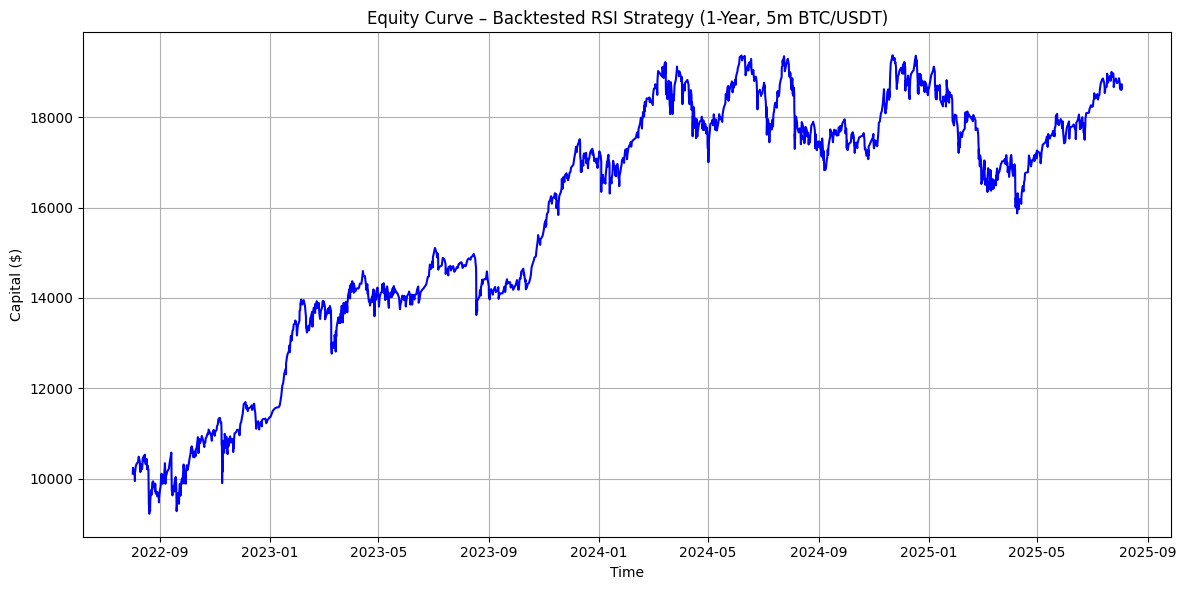

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(trades_df["Exit Time"], trades_df["Equity"], color='blue')
plt.title("Equity Curve – Backtested RSI Strategy (1-Year, 5m BTC/USDT)")
plt.xlabel("Time")
plt.ylabel("Capital ($)")
plt.grid(True)
plt.tight_layout()
plt.savefig("rsi_equity_curve.png")
